In [ ]:
#'/content/drive/My Drive/Colab_Notebooks/BIM_RecognitionSystem/final_model.keras'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model weights loaded successfully.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)   

Saving 221.jpg to 221.jpg


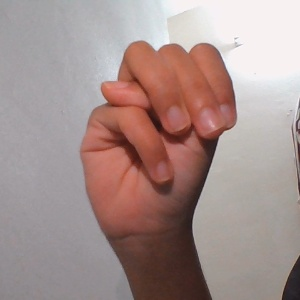

1/1 [==============================] - 0s 234ms/step
Prediction: P
Was the prediction correct? (y/n): n
The predicted class was P. Please enter the correct class (A-Z): M
Skipping malformed log entry: {"image_path": "Screenshot 2024-07-09 084113 (2).png", "incorrect_label": {"image_path": "Screenshot 2024-07-09 084113 (3).png", "incorrect_label": 15, "correct_label": 15}

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 4.1202 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 612ms/step - loss: 2.8964 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 554ms/step - loss: 2.9129 - accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 1s 554ms/step - loss: 1.1744 - accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 1s 590ms/step - loss: 0.4072 - accuracy: 1.0000
Model fine-tuned with corrected labels.


In [ ]:
import os
from google.colab import drive
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab.patches import cv2_imshow
from google.colab import files
import json

# Function to preprocess frame for prediction
def preprocess_frame(frame):
    resized_frame = cv2.resize(frame, (224, 224))
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    normalized_frame = rgb_frame / 255.0
    preprocessed_frame = np.expand_dims(normalized_frame, axis=0)
    return preprocessed_frame

# Function to make predictions on frame
def predict_sign_language(frame):
    preprocessed_frame = preprocess_frame(frame)
    prediction = model.predict(preprocessed_frame)
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class

# Function to log incorrect predictions and correct labels
def log_incorrect_prediction(image_path, incorrect_label, correct_label):
    log_entry = {
        'image_path': image_path,
        'incorrect_label': int(incorrect_label),  # Convert to native Python int
        'correct_label': int(correct_label)       # Convert to native Python int
    }
    with open('correction_log.json', 'a') as log_file:
        json.dump(log_entry, log_file)
        log_file.write('\n')

# Function to allow user to correct the prediction
def correct_prediction(predicted_class):
    correct_label = input(f"The predicted class was {chr(predicted_class + ord('A'))}. Please enter the correct class (A-Z): ")
    correct_label = correct_label.upper()
    correct_class = ord(correct_label) - ord('A')
    return correct_class

# Number of classes
num_classes = 24

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Mount Google Drive
drive.mount('/content/drive')

# Path to model weights
model_weights_path = '/content/drive/My Drive/Colab_Notebooks/BIM_RecognitionSystem/final_model.keras'

# Check if the model weights file exists and load weights
if (os.path.exists(model_weights_path)):
    model.load_weights(model_weights_path)
    print("Model weights loaded successfully.")
else:
    print(f"File '{model_weights_path}' not found.")

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()

# Function to upload and predict image
def upload_and_predict():
    uploaded = files.upload()

    for img_name in uploaded.keys():
        # Load image
        img = cv2.imread(img_name)
        if img is None:
            print(f"Error loading image {img_name}")
            continue

        # Display the uploaded image
        cv2_imshow(img)

        # Predict the sign language gesture
        prediction = predict_sign_language(img)
        prediction_letter = chr(prediction[0] + ord('A'))  # Convert to corresponding letter
        print(f"Prediction: {prediction_letter}")

        # Ask the user if the prediction was correct
        correct = input(f"Was the prediction correct? (y/n): ").strip().lower()
        if correct == 'n':
            correct_class = correct_prediction(prediction[0])
            log_incorrect_prediction(img_name, prediction[0], correct_class)

# Function to fine-tune the model using logged incorrect predictions
def fine_tune_model():
    if not os.path.exists('correction_log.json'):
        print("No correction log found. Skipping fine-tuning.")
        return

    corrections = []
    with open('correction_log.json', 'r') as log_file:
        for line in log_file:
            try:
                corrections.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"Skipping malformed log entry: {line}")
                continue

    # Prepare the data for fine-tuning
    images = []
    labels = []

    for entry in corrections:
        img = cv2.imread(entry['image_path'])
        if img is not None:
            preprocessed_img = preprocess_frame(img)
            images.append(preprocessed_img[0])  # Append the 3D image array
            labels.append(entry['correct_label'])

    if not images:
        print("No valid images found for fine-tuning.")
        return

    images = np.array(images)
    labels = np.array(labels)

    # Convert labels to one-hot encoding
    labels = np.eye(num_classes)[labels]

    # Fine-tune the model
    model.fit(images, labels, epochs=5, batch_size=8)

    print("Model fine-tuned with corrected labels.")

# Start upload and prediction process
upload_and_predict()

# Fine-tune the model if there are logged corrections
fine_tune_model()


Saving 26.jpg to 26 (1).jpg


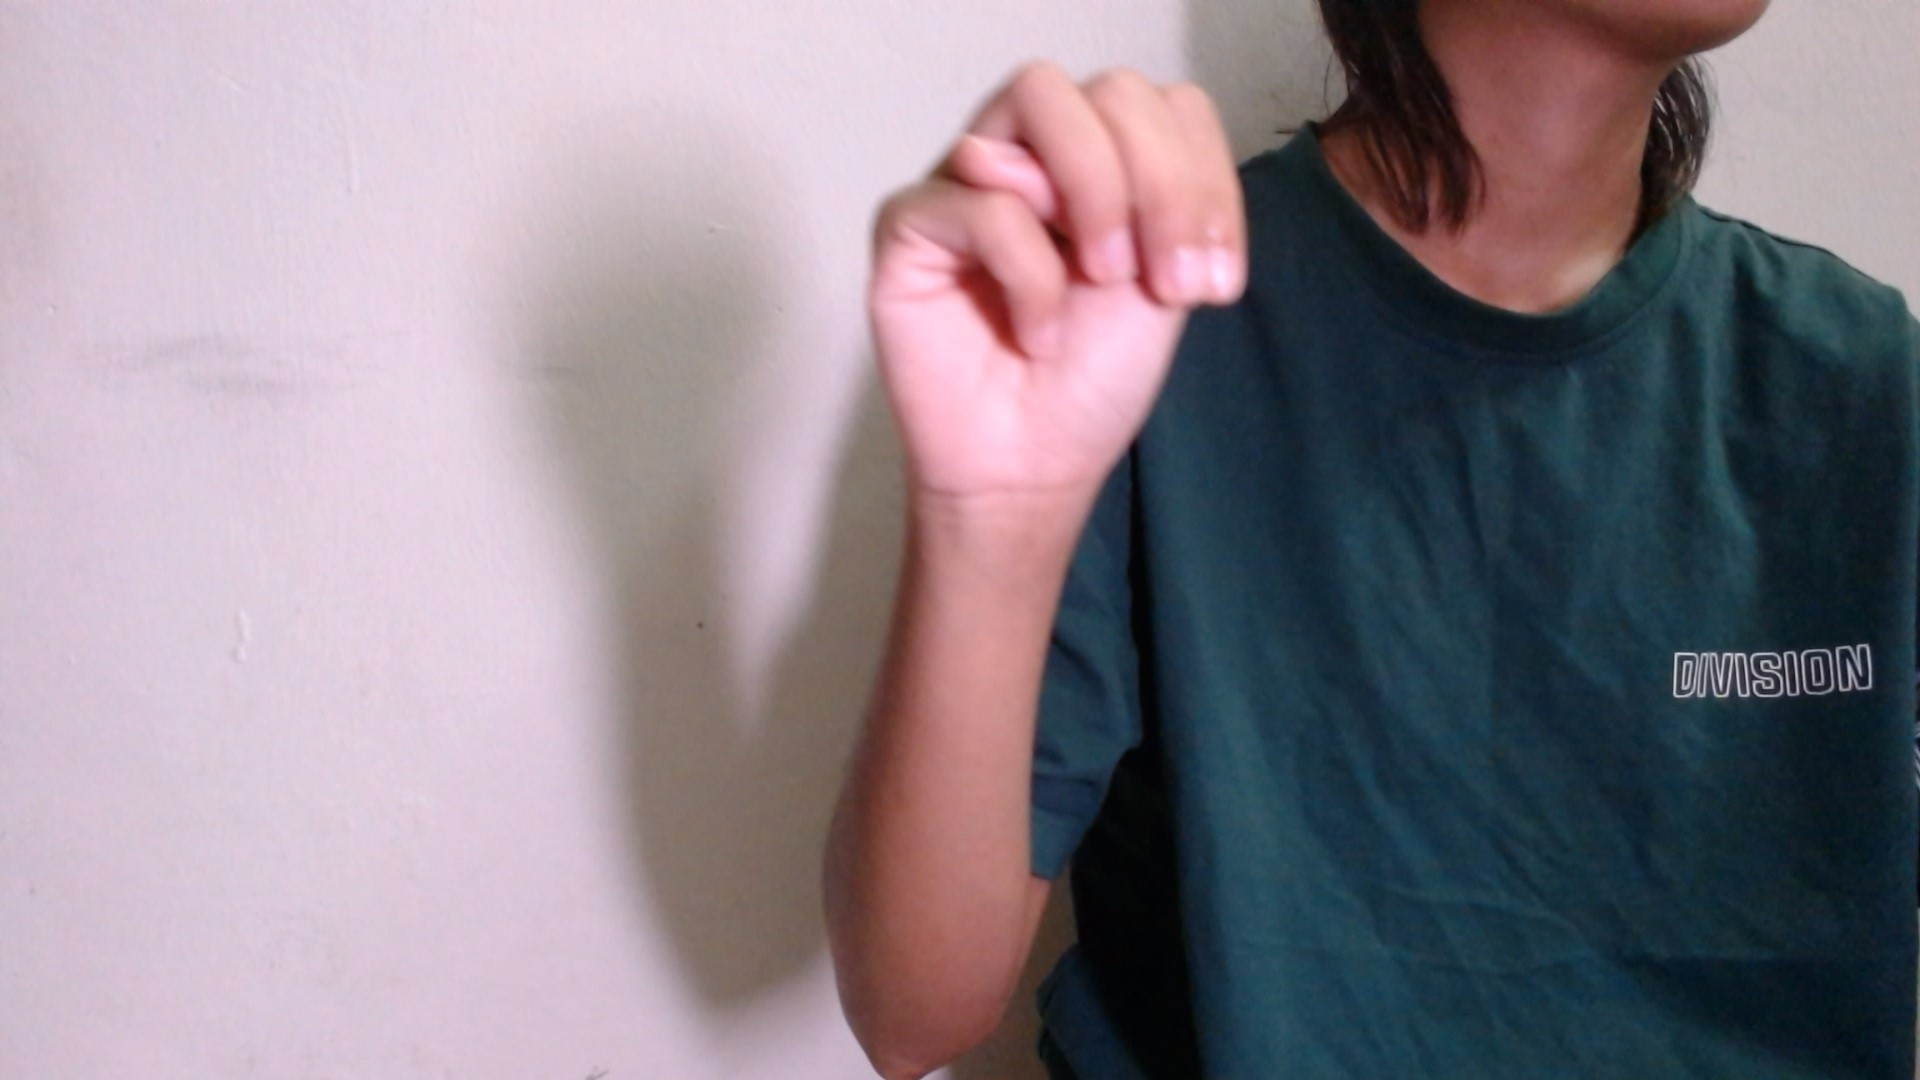

1/1 [==============================] - 0s 107ms/step
New Prediction after fine-tuning: N


In [ ]:
# Cell to re-upload and test the same image after fine-tuning
def reupload_and_predict():
    uploaded = files.upload()

    for img_name in uploaded.keys():
        # Load image
        img = cv2.imread(img_name)
        if img is None:
            print(f"Error loading image {img_name}")
            continue

        # Display the uploaded image
        cv2_imshow(img)

        # Predict the sign language gesture
        prediction = predict_sign_language(img)
        prediction_letter = chr(prediction[0] + ord('A'))  # Convert to corresponding letter
        print(f"New Prediction after fine-tuning: {prediction_letter}")

# Start re-upload and prediction process
reupload_and_predict()
